In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set_theme(style="darkgrid")


In [22]:
print("📂 Please upload your Excel file (.xlsx)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)

print("✅ Data Loaded Successfully")
print("Shape:", data.shape)
data.head()

📂 Please upload your Excel file (.xlsx)


Saving Online Retail.xlsx to Online Retail (1).xlsx
✅ Data Loaded Successfully
Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [23]:
print("\nMissing values before cleaning:\n", data.isnull().sum())

data = data.dropna(subset=['CustomerID', 'Description'])

data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]

data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

print("\nData after cleaning:", data.shape)
data.head()



Missing values before cleaning:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data after cleaning: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [24]:
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

Snapshot Date: 2011-12-10 12:50:00


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [25]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm[['R','F','M']].astype(int).sum(axis=1)
rfm['RFM_Label'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Label
0,12346.0,326,1,77183.60,1,1,4,6,114
1,12347.0,2,7,4310.00,4,4,4,12,444
2,12348.0,75,4,1797.24,2,3,4,9,234
3,12349.0,19,1,1757.55,3,1,4,8,314
4,12350.0,310,1,334.40,1,1,2,4,112


In [26]:
def categorize(score):
    if score >= 10:
        return 'Champions'
    elif score >= 8:
        return 'Loyal'
    elif score >= 6:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'Need Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(categorize)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Label,Segment
0,12346.0,326,1,77183.60,1,1,4,6,114,Potential Loyalist
1,12347.0,2,7,4310.00,4,4,4,12,444,Champions
2,12348.0,75,4,1797.24,2,3,4,9,234,Loyal
3,12349.0,19,1,1757.55,3,1,4,8,314,Loyal
4,12350.0,310,1,334.40,1,1,2,4,112,Need Attention


/tmp/ipython-input-1824919805.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm['Segment'].value_counts().index,


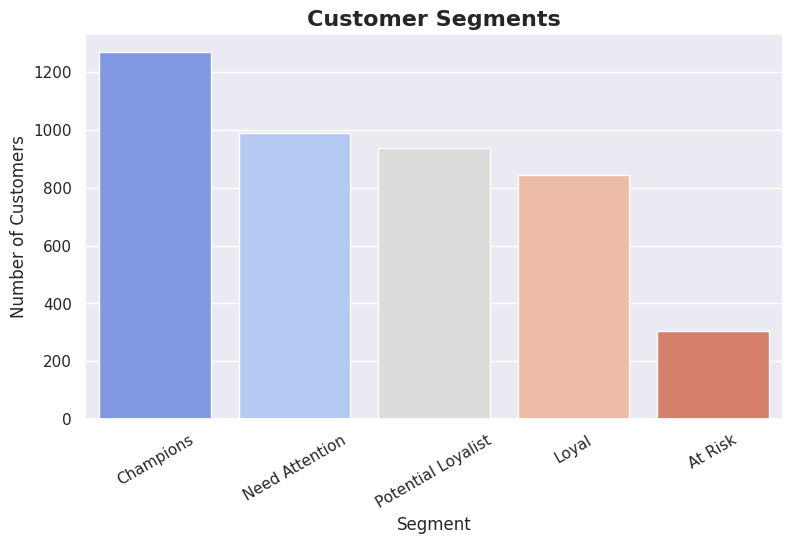

In [27]:
plt.figure(figsize=(9,5))
sns.barplot(x=rfm['Segment'].value_counts().index,
            y=rfm['Segment'].value_counts().values,
            palette="coolwarm")
plt.title("Customer Segments", fontsize=16, fontweight="bold")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()

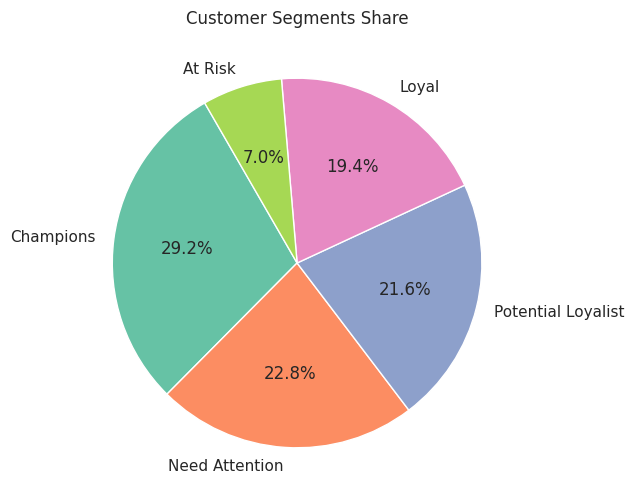

In [28]:
plt.figure(figsize=(6,6))
rfm['Segment'].value_counts().plot.pie(autopct="%.1f%%",
                                       colors=sns.color_palette("Set2"),
                                       startangle=120,
                                       wedgeprops={'edgecolor':'white'})
plt.title("Customer Segments Share")
plt.ylabel("")
plt.show()

/tmp/ipython-input-488903426.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Segment', y='Recency', palette="muted")


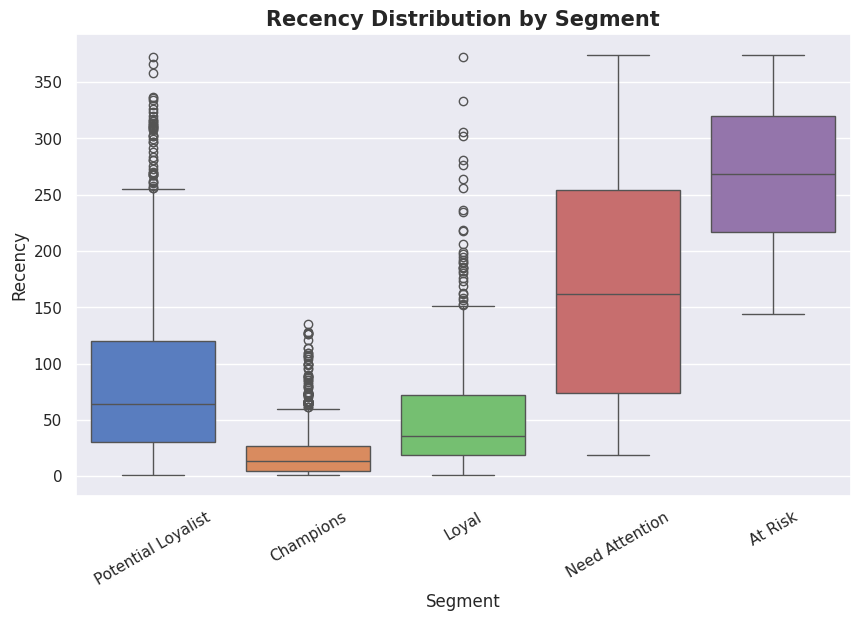

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Recency', palette="muted")
plt.title("Recency Distribution by Segment", fontsize=15, fontweight="bold")
plt.xticks(rotation=30)
plt.show()

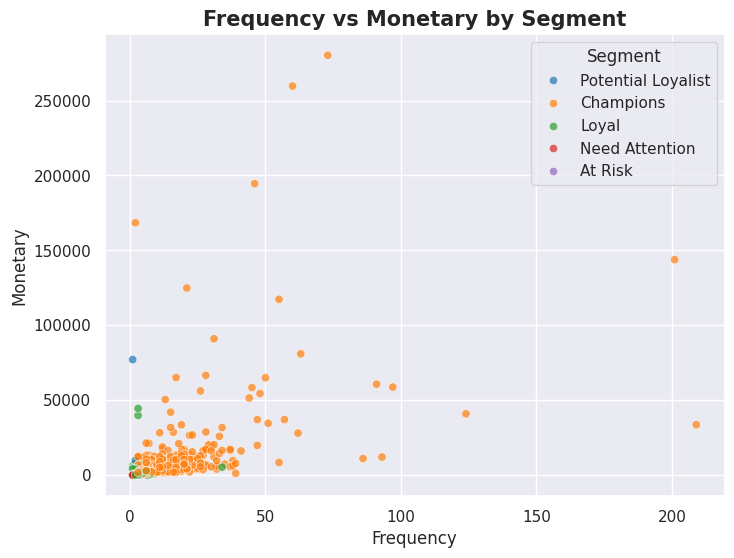

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette="tab10", alpha=0.7)
plt.title("Frequency vs Monetary by Segment", fontsize=15, fontweight="bold")
plt.show()

In [32]:
rfm['R'] = rfm['R'].astype(int)
rfm['F'] = rfm['F'].astype(int)
rfm['M'] = rfm['M'].astype(int)

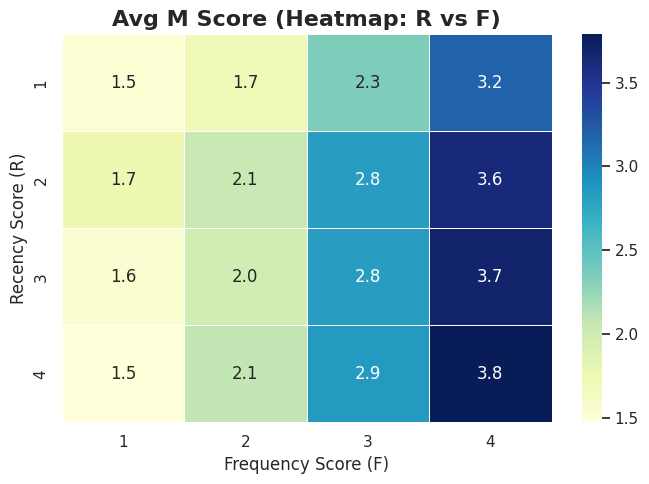

In [33]:
pivot = rfm.pivot_table(index='R', columns='F', values='M', aggfunc='mean')

plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=.5)
plt.title('Avg M Score (Heatmap: R vs F)', fontsize=16, weight='bold')
plt.xlabel('Frequency Score (F)')
plt.ylabel('Recency Score (R)')
plt.tight_layout()
plt.show()

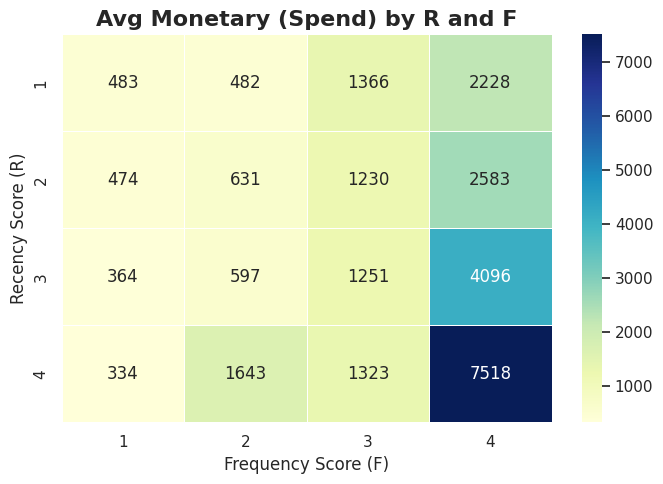

In [34]:
pivot_money = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')

plt.figure(figsize=(7,5))
sns.heatmap(pivot_money, annot=True, cmap='YlGnBu', fmt=".0f", linewidths=.5)
plt.title('Avg Monetary (Spend) by R and F', fontsize=16, weight='bold')
plt.xlabel('Frequency Score (F)')
plt.ylabel('Recency Score (R)')
plt.tight_layout()
plt.show()